In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import uproot
uproot.open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource
import awkward as ak
import sklearn.metrics as m
import os
import pandas as pd

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from scipy import interpolate
from cycler import cycler
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

In [34]:
sample = {
    'HC_4FSFxFx': '/data/pubfs/fudawei/cHZZ_postprocess/samples/predict/mc/2018/HC_4FSFxFx.root',
    'ggH': '/data/pubfs/fudawei/cHZZ_postprocess/samples/predict/mc/2018/ggH125.root',
}

events = {}
for s in sample:
    events[s] = NanoEventsFactory.from_root(
        #file='/eos/cms/store/data/Run2016B/SinglePhoton/NANOAOD/ver2_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/2430000/0BC6889E-78AB-D54A-9DAC-DD961CED79FE.root',
        #file='/eos/user/d/dfu/samples/ZpToHGamma_M2200/0/mc2018.root',
        #file='https://stash.osgconnect.net/+fudawei/samples/mc/2018/ZpToHG/ZpToHGamma_M2000/0/mc2018.root',
        file=sample[s],
        treepath='Events', schemaclass=BaseSchema
    ).events()

In [35]:
def sample_compare_plot(arrays, plot_name: str, x_name: str, year: str, bins=40, x_min=0, x_max=3000, density=True, overflow=True, underflow=False, log=False):
    bin_width = (x_max-x_min)/bins
    ## canvas initializing
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=year, ax=ax, llabel='Simulation')
    
    
    ## plot
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        hep.histplot(h, bins=hist.axes[0].edges, xerr=bin_width/2, yerr=error_bar(h, var, type='mc'), label=k, histtype='step', density=density, stack=False, ax=ax, linewidth=2)


    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
        ax.set_yscale('log')
    else:
        ax.set_ylim(0, ax.get_ylim()[1]*1.1)
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=18)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')


    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

In [36]:
arrays = {s: events[s].H_pt for s in events}
sample_compare_plot(arrays, plot_name='H_pt', x_name=r'H_pt', year=2018, x_max=200)
arrays = {s: events[s].cleanedjet_leadc2c_H_ptrel for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_H_ptrel', x_name=r'cleanedjet_leadc2c_H_ptrel', year=2018, x_max=10)
arrays = {s: events[s].cleanedjet_leadc2c_mass for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_mass', x_name=r'cleanedjet_leadc2c_mass', year=2018, x_max=30)


/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


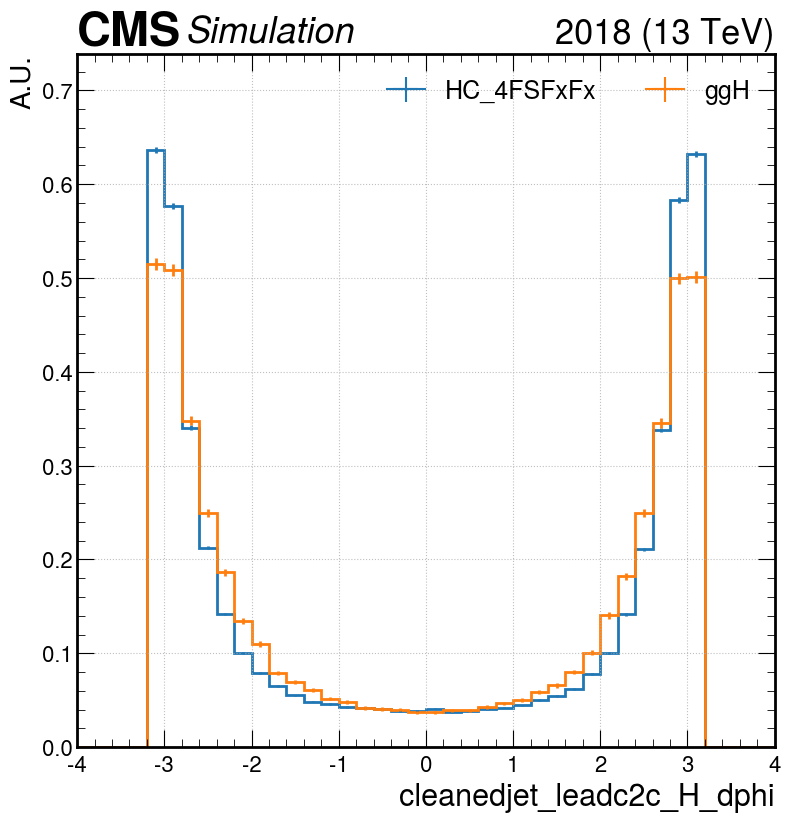

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


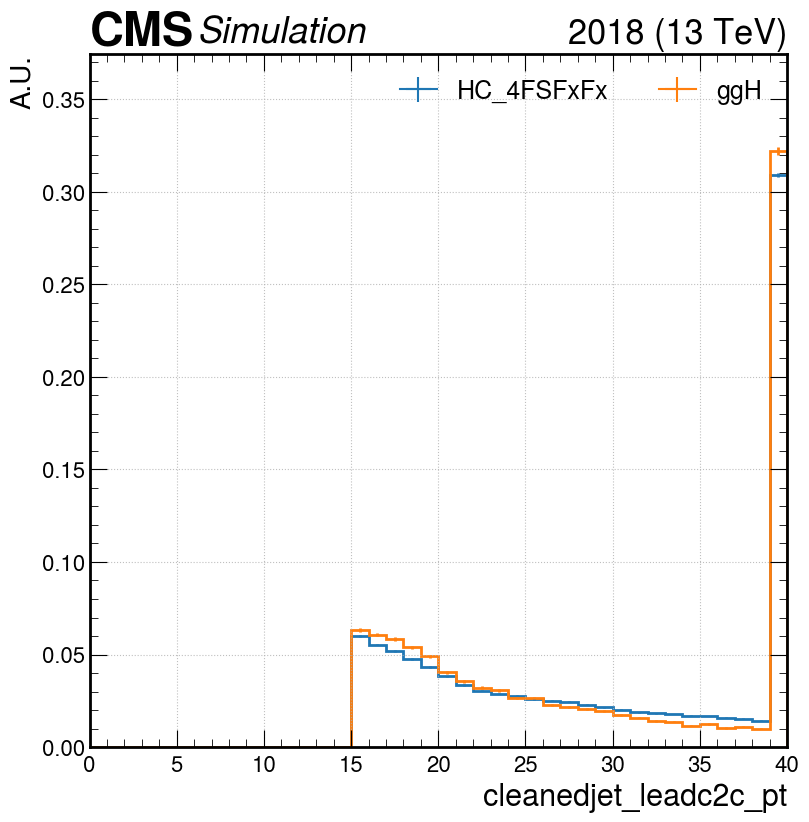

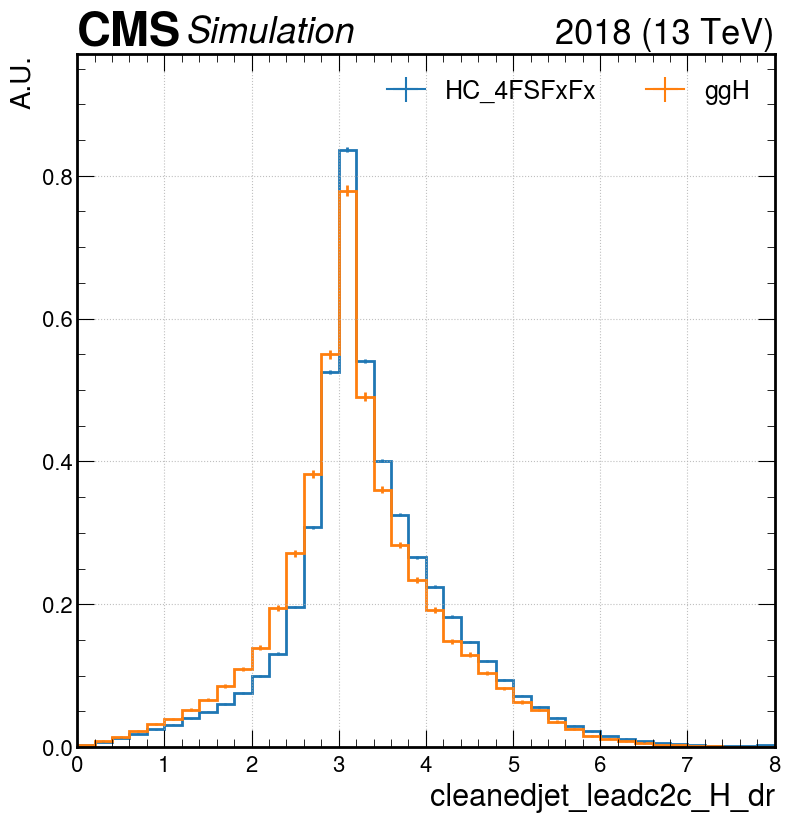

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


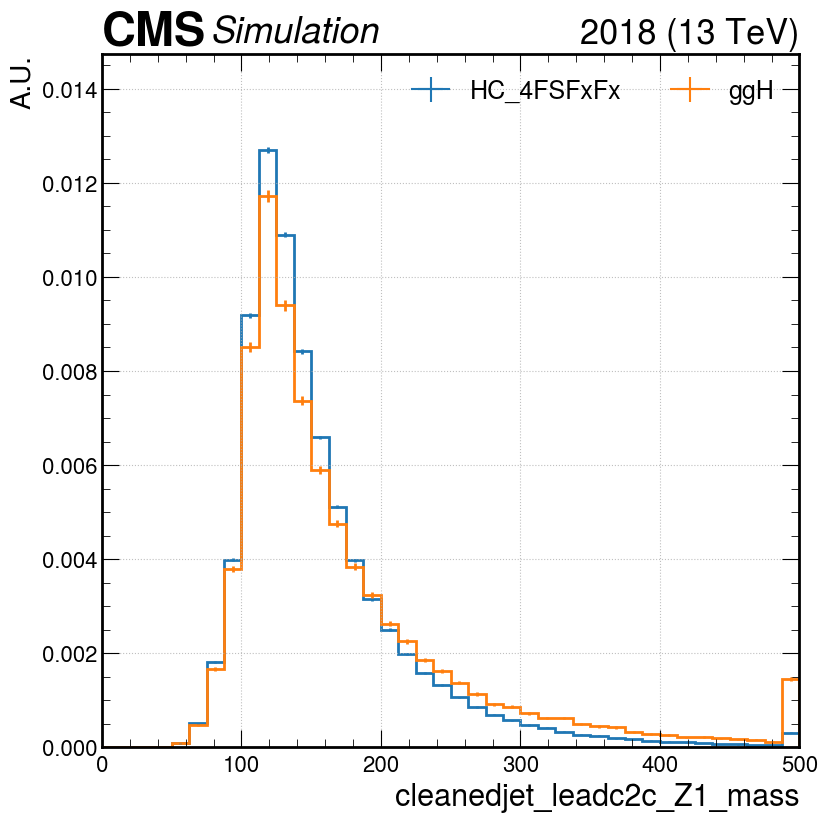

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


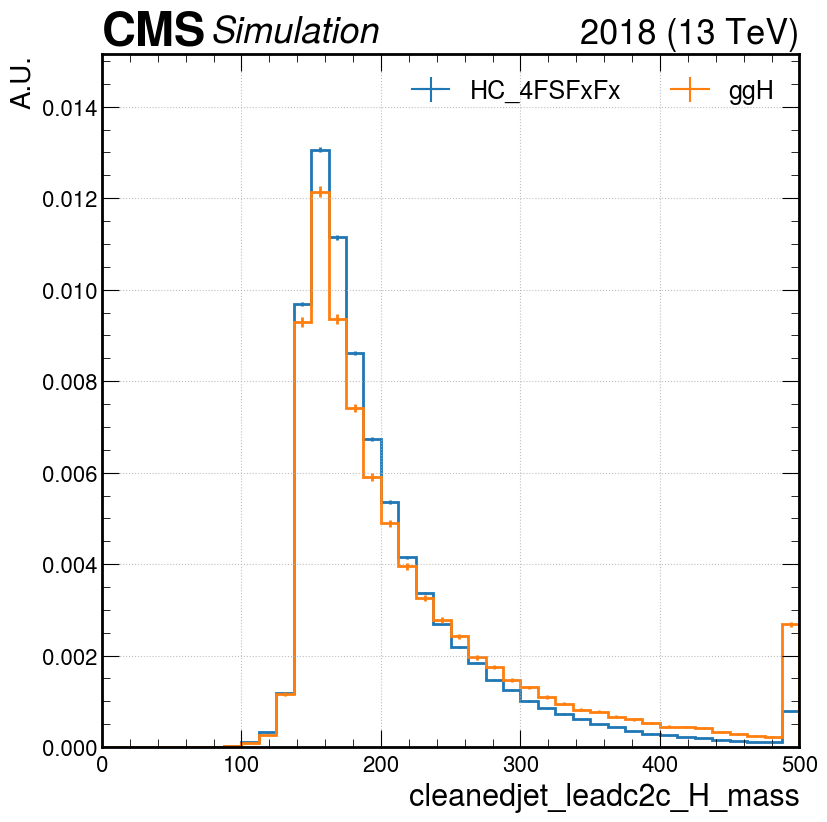

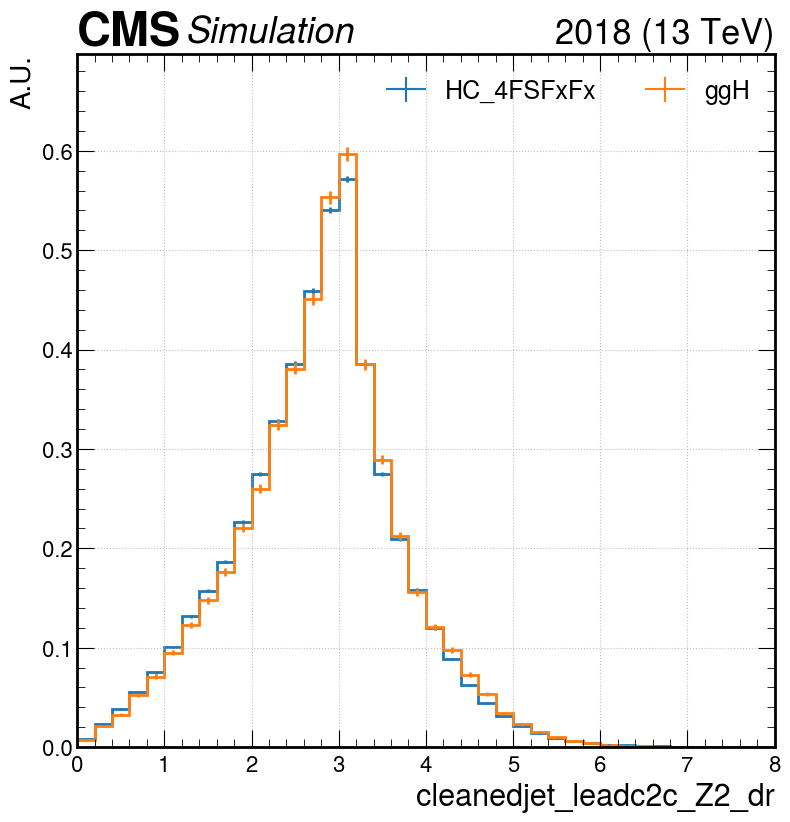

In [ ]:
arrays = {s: events[s].cleanedjet_leadc2c_H_dphi for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_H_dphi', x_name='cleanedjet_leadc2c_H_dphi', year=2018, x_min=-4, x_max=4)
arrays = {s: events[s].cleanedjet_leadc2c_pt for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_pt', x_name='cleanedjet_leadc2c_pt', year=2018, x_max=40)
arrays = {s: events[s].cleanedjet_leadc2c_H_dr for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_H_dr', x_name='cleanedjet_leadc2c_H_dr', year=2018, x_max=8)
arrays = {s: events[s].cleanedjet_leadc2c_Z1_mass for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z1_mass', x_name='cleanedjet_leadc2c_Z1_mass', year=2018, x_max=500)
arrays = {s: events[s].cleanedjet_leadc2c_H_mass for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_H_mass', x_name='cleanedjet_leadc2c_H_mass', year=2018, x_max=500)
arrays = {s: events[s].cleanedjet_leadc2c_Z2_dr for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z2_dr', x_name='cleanedjet_leadc2c_Z2_dr', year=2018, x_max=8)

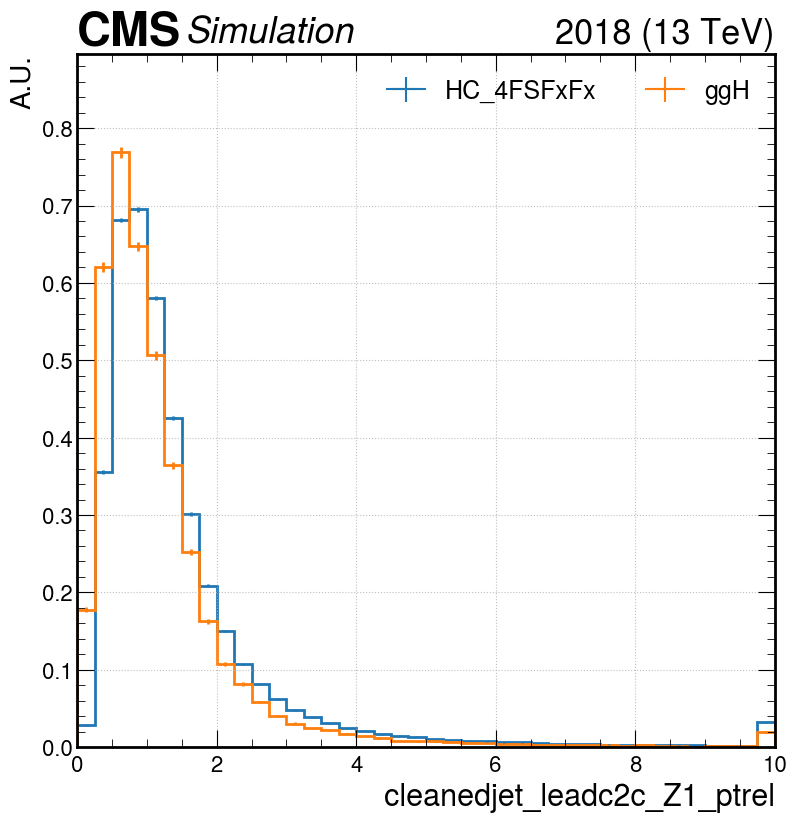

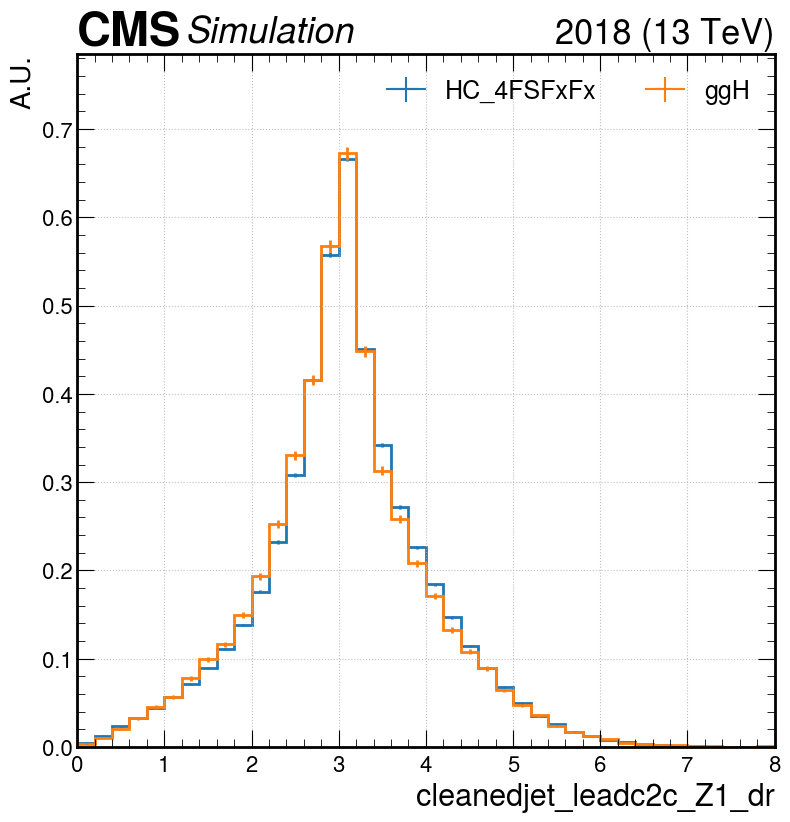

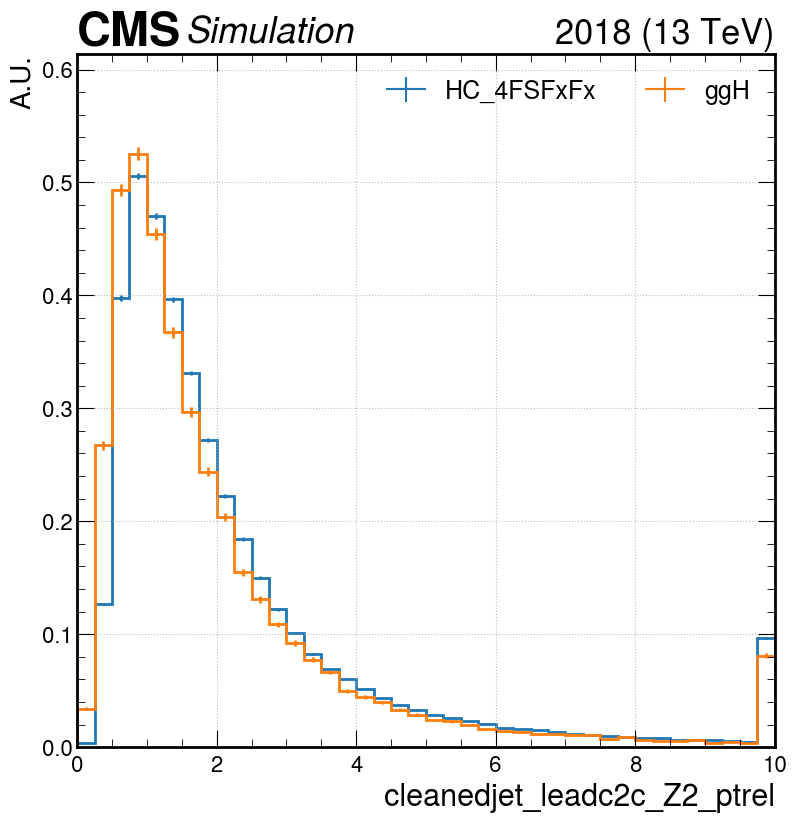

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


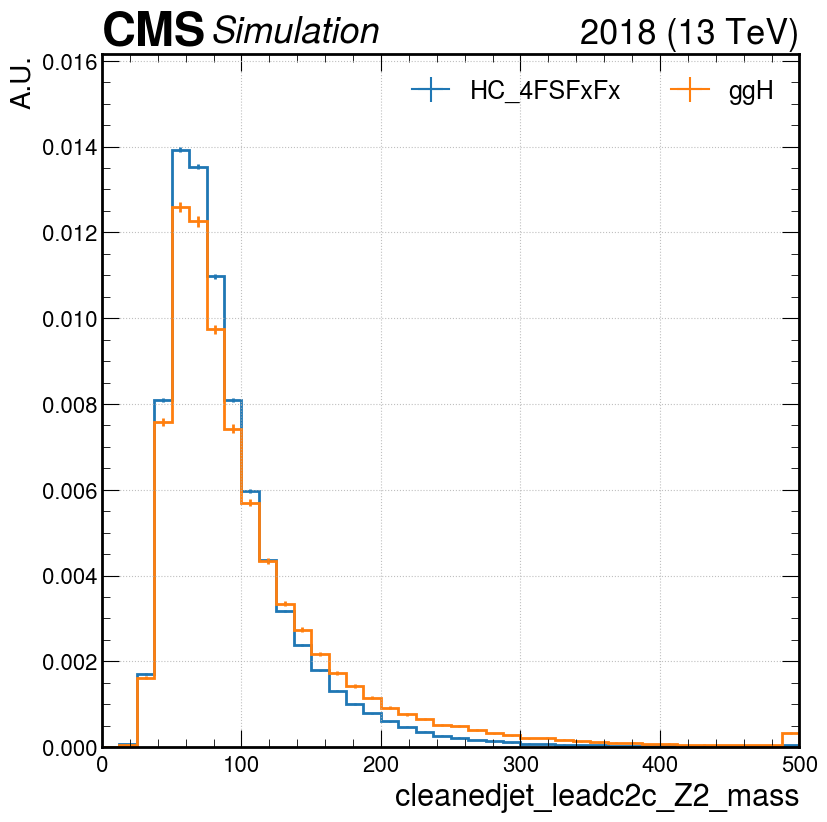

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


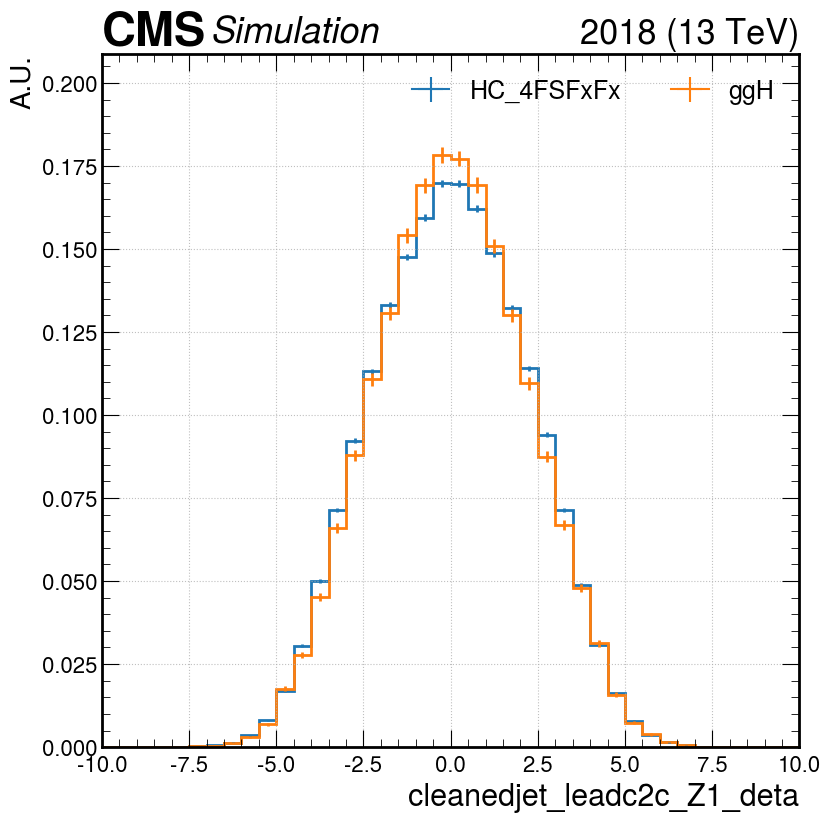

In [ ]:
arrays = {s: events[s].cleanedjet_leadc2c_Z1_ptrel for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z1_ptrel', x_name='cleanedjet_leadc2c_Z1_ptrel', year=2018, x_max=10)
arrays = {s: events[s].cleanedjet_leadc2c_Z1_dr for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z1_dr', x_name='cleanedjet_leadc2c_Z1_dr', year=2018, x_max=8)
arrays = {s: events[s].cleanedjet_leadc2c_Z2_ptrel for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z2_ptrel', x_name='cleanedjet_leadc2c_Z2_ptrel', year=2018, x_max=10)
arrays = {s: events[s].cleanedjet_leadc2c_Z2_mass for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z2_mass', x_name='cleanedjet_leadc2c_Z2_mass', year=2018, x_max=500)
arrays = {s: events[s].cleanedjet_leadc2c_Z1_deta for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z1_deta', x_name='cleanedjet_leadc2c_Z1_deta', year=2018, x_min=-10, x_max=10)

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


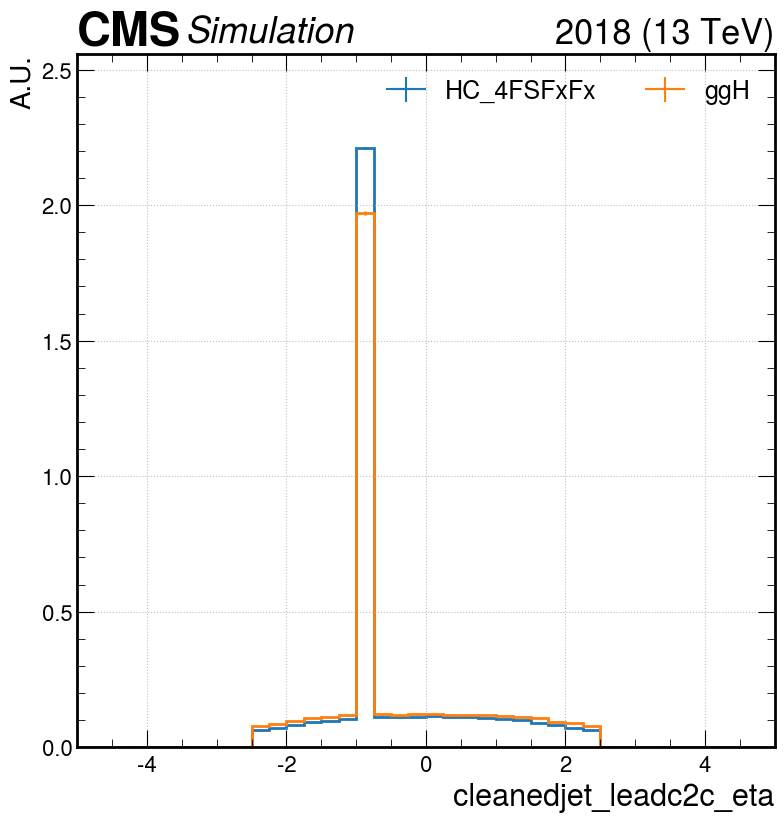

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


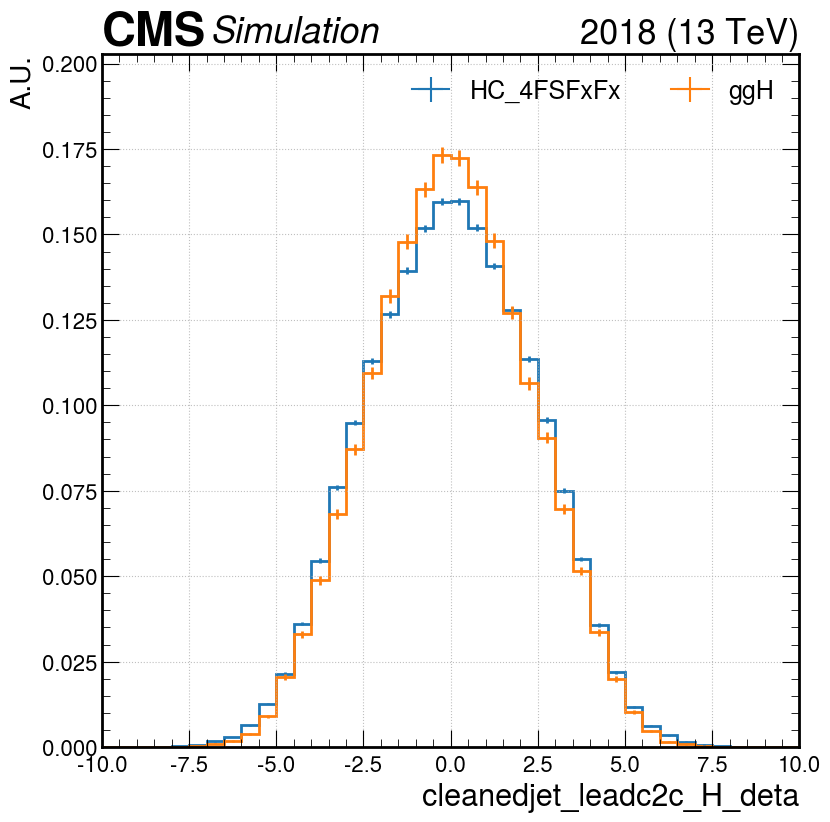

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


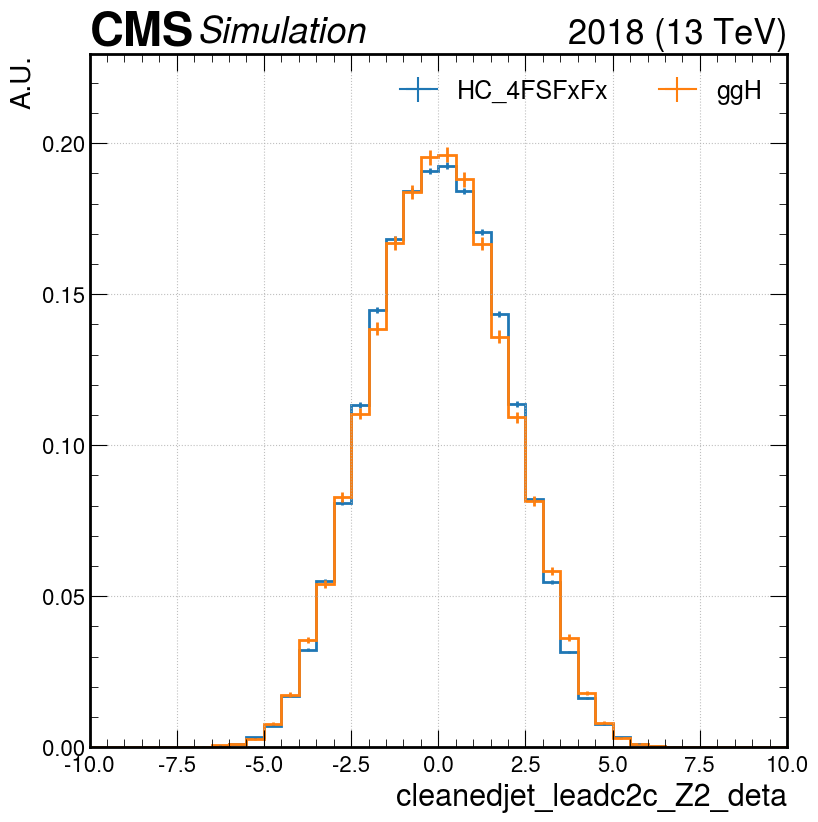

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


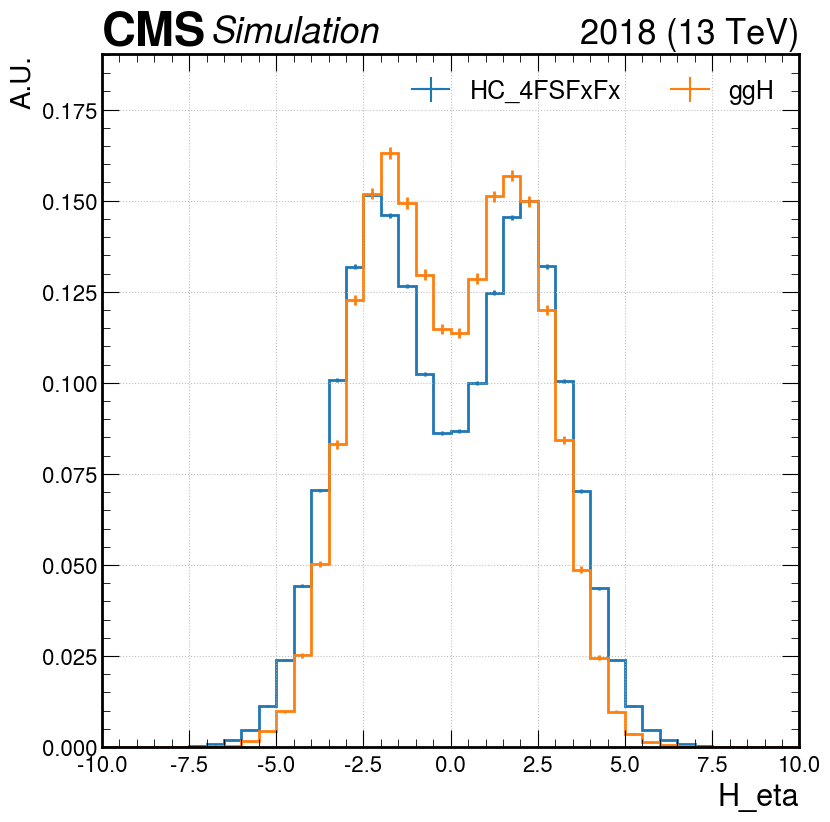

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


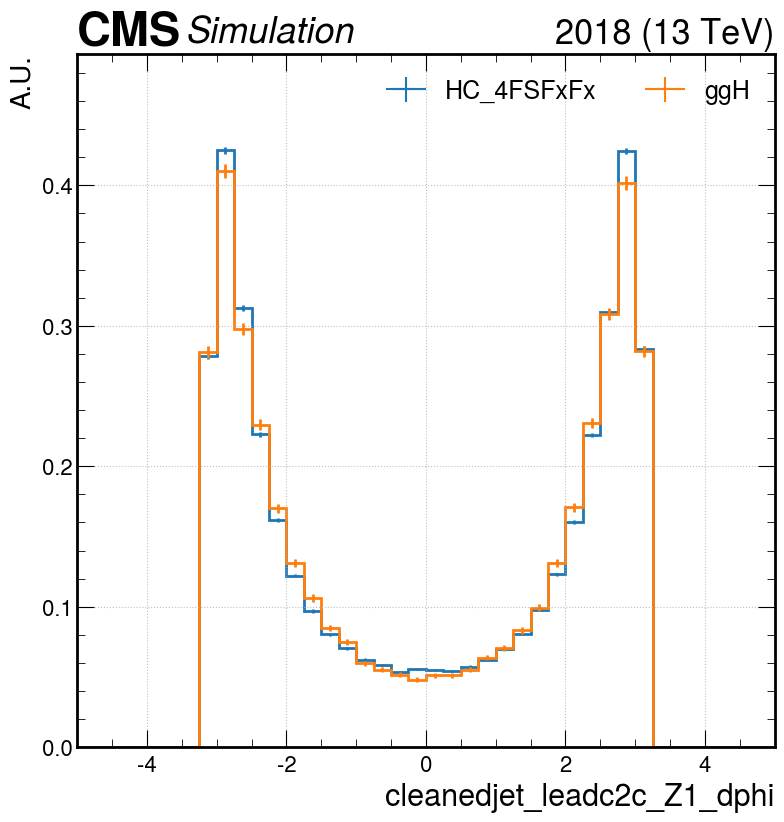

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


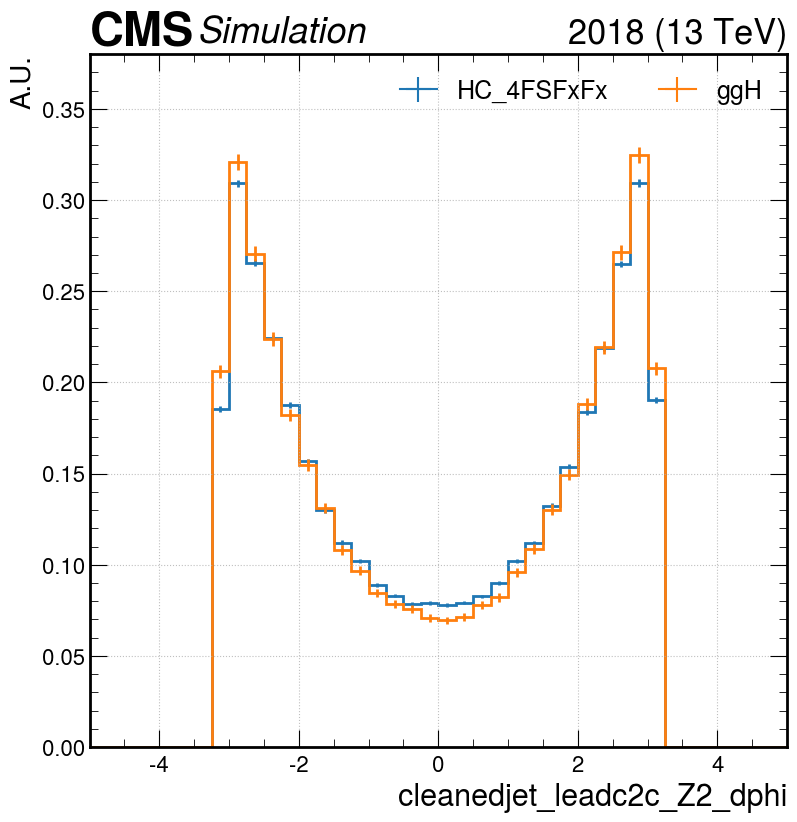

In [ ]:
arrays = {s: events[s].cleanedjet_leadc2c_eta for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_eta', x_name='cleanedjet_leadc2c_eta', year=2018, x_min=-5, x_max=5)
arrays = {s: events[s].cleanedjet_leadc2c_H_deta for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_H_deta', x_name='cleanedjet_leadc2c_H_deta', year=2018, x_min=-10, x_max=10)
arrays = {s: events[s].cleanedjet_leadc2c_Z2_deta for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z2_deta', x_name='cleanedjet_leadc2c_Z2_deta', year=2018, x_min=-10, x_max=10)
arrays = {s: events[s].H_eta for s in events}
sample_compare_plot(arrays, plot_name='H_eta', x_name='H_eta', year=2018, x_min=-10, x_max=10)
arrays = {s: events[s].cleanedjet_leadc2c_Z1_dphi for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z1_dphi', x_name='cleanedjet_leadc2c_Z1_dphi', year=2018, x_min=-5, x_max=5)
arrays = {s: events[s].cleanedjet_leadc2c_Z2_dphi for s in events}
sample_compare_plot(arrays, plot_name='cleanedjet_leadc2c_Z2_dphi', x_name='cleanedjet_leadc2c_Z2_dphi', year=2018, x_min=-5, x_max=5)

/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:47: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1363004/2813913167.py:63: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1363004/2813913167.py:64: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


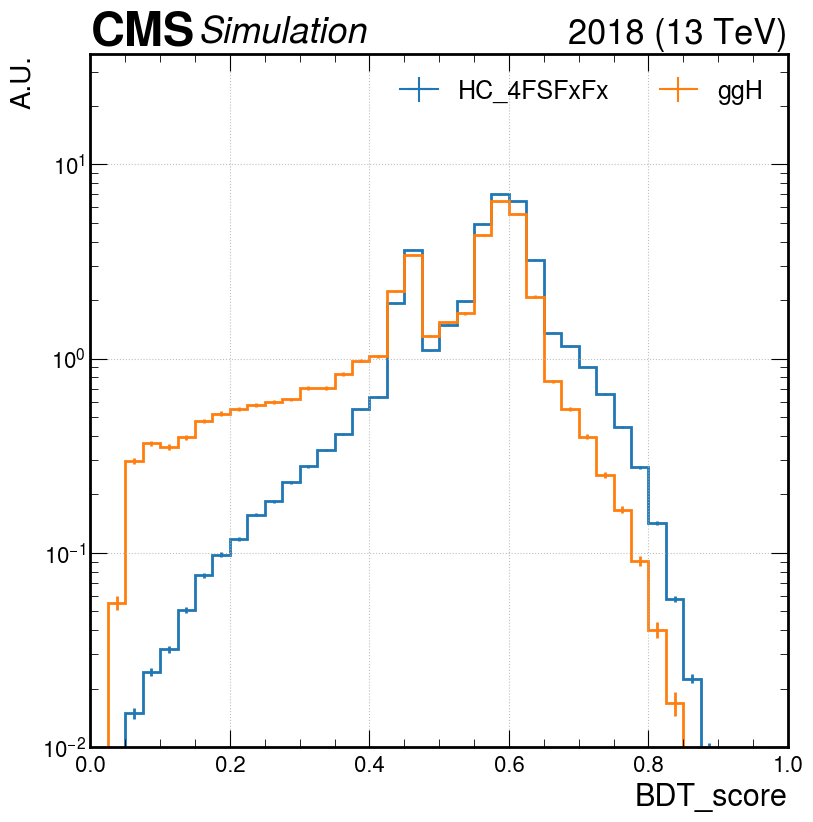

In [ ]:
arrays = {s: events[s]['bdt_score'] for s in events}
sample_compare_plot(arrays, plot_name='BDT_score', x_name='BDT_score', year=2018, x_max=1, log=True)

In [ ]:
y_true = np.concatenate([
    np.ones_like(events['HC_4FSFxFx']['bdt_score']), 
    np.zeros_like(events['ggH']['bdt_score'])
], axis=0)

y_score = np.concatenate([
    events['HC_4FSFxFx']['bdt_score'],
    events['ggH']['bdt_score']
], axis=0)

ValueError: key interpreted as fieldindex 20230403 for records with only 22 fields

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.2/src/libawkward/util.cpp#L531)

In [ ]:
def plot_ROC(y_true, y_score, x_label, y_label, legend_location='best'):
    """
    events: a dictionary, events.values() are collections of events
    """
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=2018, ax=ax, fontname='sans-serif')
    #plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','darkviolet'])
    
    plt.plot([plt.xlim()[0],plt.xlim()[1]], [0.01,0.01], linestyle="dashed", lw=2, color='gray')
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score, pos_label=1)
    plt.plot(tpr, fpr, linestyle="solid", lw=2, label='BDT(AUC=%.3f)'%roc_auc_score(y_true, y_score))
    index=np.where(fpr==min(fpr, key=lambda x:abs(x-0.01), ))[0]
    plt.plot([tpr[index], tpr[index]], [plt.ylim()[0], 0.01], linestyle="dashed", lw=2, color='gray')
        
    plt.xlim(0, 1)
    plt.ylim(1e-4,1)
    x_major_locator=plt.MultipleLocator(0.1)
    #y_major_locator=MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel(f'{x_label} efficiency', fontsize=24, ha='right', x=1)
    plt.ylabel(f'Mistag rate ({y_label})', fontsize=24, ha='right', y=1)
    plt.yscale('log')
    plt.xticks(size=14)
    plt.yticks(size=14)

    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc=legend_location,frameon=False,fontsize=20)
    #plt.text(0.03, 0.4e-0, x_label + " vs. "+y_label, fontsize=26, color="black")
    #plt.text(0.03, 0.2e-0, rf"$\rm {pt_min}GeV<p_T<{pt_max}GeV,\ |\eta|<{abs_eta_max},\ \rm {mass_min}GeV<m_{{SD}}<{mass_max}GeV$", fontsize=16,color="black")
    #plt.text(0.1, 0.9e-1,r"$\rm 90GeV<m_{SD}<140GeV$", fontsize=16,color="black")
    #plt.text(0.1, 0.2e-1,"AUC(MD)=%.4f"%(roc_auc_new), fontsize=20,color="red")
    #plt.text(0.5, 0.2e-3,"AUC(non-MD)=%.4f"%(roc_auc_old), fontsize=20,color='blue')

    
    plt.savefig(f"plots/ROC_{y_label}_{x_label}.pdf", bbox_inches='tight')
    plt.show()

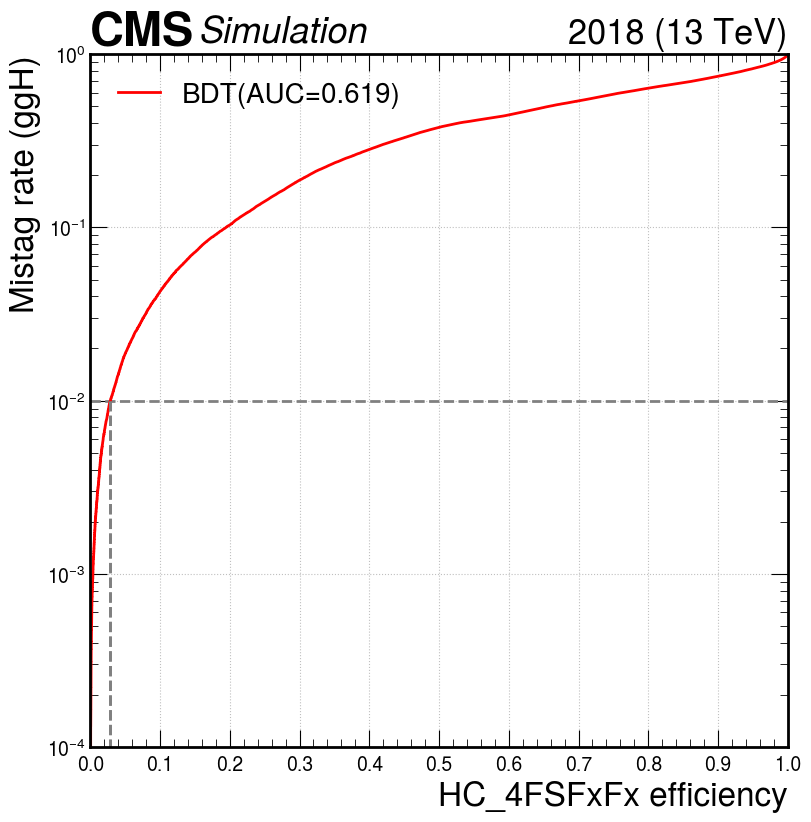

In [ ]:
plot_ROC(y_true, y_score, x_label='HC_4FSFxFx', y_label='ggH')

In [ ]:
text = [
    """
    1.                     H_pt: 624.8403930664062
    2. cleanedjet_leadc2c_H_ptrel: 234.54513549804688
    3.  cleanedjet_leadc2c_mass: 83.40491485595703
    4. cleanedjet_leadc2c_H_dphi: 81.13009643554688
    5.    cleanedjet_leadc2c_pt: 65.12355041503906
    6.  cleanedjet_leadc2c_H_dr: 47.29230880737305
    7. cleanedjet_leadc2c_Z1_mass: 41.5384635925293
    8. cleanedjet_leadc2c_H_mass: 33.07715606689453
    9. cleanedjet_leadc2c_Z2_dr: 28.459640502929688
    10. cleanedjet_leadc2c_Z1_ptrel: 25.984996795654297
    11. cleanedjet_leadc2c_Z1_dr: 25.715713500976562
    12. cleanedjet_leadc2c_Z2_ptrel: 23.61906623840332
    13. cleanedjet_leadc2c_Z2_mass: 22.509525299072266
    14. cleanedjet_leadc2c_Z1_deta: 22.340593338012695
    15.   cleanedjet_leadc2c_eta: 21.045785903930664
    16. cleanedjet_leadc2c_H_deta: 20.92597770690918
    17. cleanedjet_leadc2c_Z2_deta: 20.919347763061523
    18.                    H_eta: 20.088167190551758
    19. cleanedjet_leadc2c_Z1_dphi: 19.976469039916992
    20. cleanedjet_leadc2c_Z2_dphi: 17.458057403564453
    """,
    """
    1.                     H_pt: 633.1927490234375
    2. cleanedjet_leadc2c_H_ptrel: 234.22149658203125
    3.  cleanedjet_leadc2c_mass: 82.05663299560547
    4. cleanedjet_leadc2c_H_dphi: 79.18498992919922
    5.    cleanedjet_leadc2c_pt: 69.3384017944336
    6.  cleanedjet_leadc2c_H_dr: 46.70063018798828
    7. cleanedjet_leadc2c_H_mass: 40.63422775268555
    8. cleanedjet_leadc2c_Z1_mass: 39.89560317993164
    9. cleanedjet_leadc2c_Z1_dr: 24.454307556152344
    10. cleanedjet_leadc2c_Z2_dr: 23.406097412109375
    11. cleanedjet_leadc2c_Z2_deta: 23.331544876098633
    12. cleanedjet_leadc2c_Z1_deta: 21.989253997802734
    13. cleanedjet_leadc2c_Z2_ptrel: 21.832931518554688
    14. cleanedjet_leadc2c_H_deta: 21.721925735473633
    15. cleanedjet_leadc2c_Z2_mass: 21.636226654052734
    16. cleanedjet_leadc2c_Z1_ptrel: 21.275402069091797
    17.   cleanedjet_leadc2c_eta: 20.68174171447754
    18. cleanedjet_leadc2c_Z1_dphi: 19.278676986694336
    19.                    H_eta: 18.988935470581055
    20. cleanedjet_leadc2c_Z2_dphi: 17.919910430908203
    """,
    """
    1.                     H_pt: 661.5177612304688
    2. cleanedjet_leadc2c_H_ptrel: 236.6400909423828
    3.  cleanedjet_leadc2c_mass: 86.480224609375
    4. cleanedjet_leadc2c_H_dphi: 84.28942108154297
    5.    cleanedjet_leadc2c_pt: 74.21236419677734
    6.  cleanedjet_leadc2c_H_dr: 57.112998962402344
    7. cleanedjet_leadc2c_Z1_mass: 39.29001998901367
    8. cleanedjet_leadc2c_H_mass: 38.86272048950195
    9. cleanedjet_leadc2c_Z1_ptrel: 26.622631072998047
    10. cleanedjet_leadc2c_Z2_dr: 25.970056533813477
    11. cleanedjet_leadc2c_Z1_dr: 25.921123504638672
    12. cleanedjet_leadc2c_Z2_mass: 25.244159698486328
    13. cleanedjet_leadc2c_Z2_deta: 25.052385330200195
    14. cleanedjet_leadc2c_H_deta: 23.941303253173828
    15. cleanedjet_leadc2c_Z2_ptrel: 22.87576675415039
    16. cleanedjet_leadc2c_Z1_deta: 21.065576553344727
    17.   cleanedjet_leadc2c_eta: 20.38199234008789
    18. cleanedjet_leadc2c_Z1_dphi: 20.358489990234375
    19.                    H_eta: 20.186887741088867
    20. cleanedjet_leadc2c_Z2_dphi: 18.228408813476562
    """,
    """
    1.                     H_pt: 672.8162841796875
    2. cleanedjet_leadc2c_H_ptrel: 238.5728759765625
    3.  cleanedjet_leadc2c_mass: 89.885009765625
    4. cleanedjet_leadc2c_H_dphi: 80.4024887084961
    5.    cleanedjet_leadc2c_pt: 74.75953674316406
    6.  cleanedjet_leadc2c_H_dr: 52.45112991333008
    7. cleanedjet_leadc2c_Z1_mass: 45.85990524291992
    8. cleanedjet_leadc2c_H_mass: 41.24420166015625
    9. cleanedjet_leadc2c_Z2_dr: 31.4645938873291
    10. cleanedjet_leadc2c_Z1_dr: 28.90801239013672
    11. cleanedjet_leadc2c_Z1_ptrel: 27.282581329345703
    12. cleanedjet_leadc2c_Z2_ptrel: 24.50263023376465
    13. cleanedjet_leadc2c_Z2_deta: 21.069982528686523
    14. cleanedjet_leadc2c_Z2_mass: 20.997657775878906
    15. cleanedjet_leadc2c_H_deta: 20.55268669128418
    16.   cleanedjet_leadc2c_eta: 20.474285125732422
    17. cleanedjet_leadc2c_Z1_deta: 20.401657104492188
    18. cleanedjet_leadc2c_Z1_dphi: 20.181852340698242
    19.                    H_eta: 20.022441864013672
    20. cleanedjet_leadc2c_Z2_dphi: 17.566162109375
    """,
    """
    1.                     H_pt: 686.446044921875
    2. cleanedjet_leadc2c_H_ptrel: 236.07772827148438
    3.  cleanedjet_leadc2c_mass: 88.4216537475586
    4. cleanedjet_leadc2c_H_dphi: 86.48196411132812
    5.    cleanedjet_leadc2c_pt: 74.9837875366211
    6.  cleanedjet_leadc2c_H_dr: 55.93119812011719
    7. cleanedjet_leadc2c_H_mass: 44.089820861816406
    8. cleanedjet_leadc2c_Z1_mass: 36.07997512817383
    9. cleanedjet_leadc2c_Z2_dr: 31.61095428466797
    10. cleanedjet_leadc2c_Z1_dr: 27.266204833984375
    11. cleanedjet_leadc2c_Z1_ptrel: 26.47845458984375
    12. cleanedjet_leadc2c_Z2_ptrel: 24.409061431884766
    13. cleanedjet_leadc2c_Z2_deta: 23.47158432006836
    14. cleanedjet_leadc2c_Z2_mass: 23.281892776489258
    15.   cleanedjet_leadc2c_eta: 22.07564353942871
    16. cleanedjet_leadc2c_H_deta: 21.92344093322754
    17. cleanedjet_leadc2c_Z1_deta: 21.589170455932617
    18. cleanedjet_leadc2c_Z1_dphi: 20.708894729614258
    19.                    H_eta: 19.03076171875
    20. cleanedjet_leadc2c_Z2_dphi: 17.02330207824707
    """,
]

In [ ]:
stats = {}
for importance in text:
    for line in importance.splitlines()[1:-1]:
        info = line.replace(':', ' ').split()
        stats[info[1]] = stats.get(info[1], 0) + float(info[2])
stats

{'H_pt': 3278.813232421875,
 'cleanedjet_leadc2c_H_ptrel': 1180.0573272705078,
 'cleanedjet_leadc2c_mass': 430.2484359741211,
 'cleanedjet_leadc2c_H_dphi': 411.4889602661133,
 'cleanedjet_leadc2c_pt': 358.41764068603516,
 'cleanedjet_leadc2c_H_dr': 259.48826599121094,
 'cleanedjet_leadc2c_Z1_mass': 202.66396713256836,
 'cleanedjet_leadc2c_H_mass': 197.9081268310547,
 'cleanedjet_leadc2c_Z2_dr': 140.9113426208496,
 'cleanedjet_leadc2c_Z1_ptrel': 127.6440658569336,
 'cleanedjet_leadc2c_Z1_dr': 132.26536178588867,
 'cleanedjet_leadc2c_Z2_ptrel': 117.23945617675781,
 'cleanedjet_leadc2c_Z2_mass': 113.66946220397949,
 'cleanedjet_leadc2c_Z1_deta': 107.38625144958496,
 'cleanedjet_leadc2c_eta': 104.65944862365723,
 'cleanedjet_leadc2c_H_deta': 109.06533432006836,
 'cleanedjet_leadc2c_Z2_deta': 113.84484481811523,
 'H_eta': 98.31719398498535,
 'cleanedjet_leadc2c_Z1_dphi': 100.5043830871582,
 'cleanedjet_leadc2c_Z2_dphi': 88.19584083557129}

In [ ]:
print('\n'.join(list(stats.keys())))

H_pt
cleanedjet_leadc2c_H_ptrel
cleanedjet_leadc2c_mass
cleanedjet_leadc2c_H_dphi
cleanedjet_leadc2c_pt
cleanedjet_leadc2c_H_dr
cleanedjet_leadc2c_Z1_mass
cleanedjet_leadc2c_H_mass
cleanedjet_leadc2c_Z2_dr
cleanedjet_leadc2c_Z1_ptrel
cleanedjet_leadc2c_Z1_dr
cleanedjet_leadc2c_Z2_ptrel
cleanedjet_leadc2c_Z2_mass
cleanedjet_leadc2c_Z1_deta
cleanedjet_leadc2c_eta
cleanedjet_leadc2c_H_deta
cleanedjet_leadc2c_Z2_deta
H_eta
cleanedjet_leadc2c_Z1_dphi
cleanedjet_leadc2c_Z2_dphi


In [ ]:
feature = list(stats.keys())
importance = list(stats.values())
feature, importance = zip(*sorted(zip(feature, importance), key=lambda x: x[1]))
df = pd.DataFrame({'feature': feature, 'importance': importance})

In [ ]:
import plotly.express as px
fig = px.bar(df, x='importance', y='feature', width=800, height=600, log_x=True, color='importance', title='BDT feature importance')
fig.show()
fig.write_image("plots/bdt_feature_importance.pdf")